In [2]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
root = Path('../').resolve()
os.chdir(root)

In [4]:
# Load the model from "create_model_from_pretrained"
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' 
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

c:\Users\Vivian\Documents\CONCH\conch\open_clip_custom\factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map

In [13]:
# Preprocess images and save tensors
def preprocess_image(image_path):
    """
    Load and preprocess an image for the CONCH model.
    Args:
        image_path (str): Path to the input image.
    Returns:
        torch.Tensor: Preprocessed image tensor ready for CONCH model input.
    """
    image = Image.open(image_path).convert("RGB")  # Ensure 3 channels (RGB)
    return preprocess(image).unsqueeze(0)  # Add batch dimension

def preprocess_dataset(dataset_path, output_path):
    """
    Preprocess the entire BreakHis dataset and save the tensors.
    Args:
        dataset_path (str): Path to the BreakHis dataset.
        output_path (str): Path to save the processed tensors.
    """
    os.makedirs(output_path, exist_ok=True)  # Create output directory if not exist

    for root, _, files in tqdm(os.walk(dataset_path)):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                tensor = preprocess_image(image_path)

                # Save the tensor with the same name as the image
                tensor_path = os.path.join(output_path, file.replace('.png', '.pt'))
                torch.save(tensor, tensor_path)

# Example usage
dataset_path = r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast"
output_path = r"C:\Users\Vivian\Documents\CONCH\data_tensors"

preprocess_dataset(dataset_path, output_path)
print("Process Complete")

423it [02:07,  3.33it/s]

Process Complete


Cell 1: Import Libraries and Define Constants

In [5]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the labels and classes
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
classes = ["adenosis (A)", "fibroadenoma (F)", "phyllodes tumor (PT)", "tubular adenona (TA)", "carcinoma (DC)", "lobular carcinoma (LC)", "mucinous carcinoma (MC)", "papillary carcinoma (PC)"]

Cell 2: Define Helper Functions

In [6]:
# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to extract features and save as CSV files
def extract_features(tensor_folder, output_folder, model, device):
    os.makedirs(output_folder, exist_ok=True)
    for tensor_file in tqdm(os.listdir(tensor_folder)):
        if tensor_file.endswith(".pt"):
            tensor_path = os.path.join(tensor_folder, tensor_file)
            tensor = torch.load(tensor_path).to(device)
            with torch.inference_mode():
                features = model.encode_image(tensor, proj_contrast=False, normalize=False)
            feature_path = os.path.join(output_folder, tensor_file.replace('.pt', '_features.csv'))
            features_df = pd.DataFrame(features.cpu().numpy())
            features_df.to_csv(feature_path, index=False)

# Function to load features and labels from CSV files
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.csv"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = pd.read_csv(feature_path).values.flatten()
            features.append(feature)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
    return np.array(features), np.array(labels)

Cell 3: Extract Features and Save as CSV Files

In [7]:
# Example usage
tensor_folder = r"C:\Users\Vivian\Documents\CONCH\data_tensors"
output_folder = r"C:\Users\Vivian\Documents\CONCH\data_features"

# Load and encode images
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
extract_features(tensor_folder, output_folder, model, device)
print("Feature extraction complete")

  0%|          | 0/7909 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_8796\1283504992.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load

Feature extraction complete


Cell 4: Load Features and Labels

In [8]:
# Load data
feature_folder = output_folder
X, y = load_features_and_labels(feature_folder, labels_list)

# Map labels to class names
y = np.array([classes[labels_list.index(label)] for label in y])

Cell 5: Train and Evaluate Logistic Regression Model

In [9]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Binarize the labels for ROC curve plotting
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test data
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))
print("Accuracy:", accuracy_score(y_test, y_pred))

LogisticRegression(max_iter=1000)

Classification Report:
                          precision    recall  f1-score   support

            adenosis (A)       0.87      0.82      0.85        97
        fibroadenoma (F)       0.89      0.91      0.90       671
    phyllodes tumor (PT)       0.89      0.84      0.87       221
    tubular adenona (TA)       0.65      0.67      0.66       120
          carcinoma (DC)       0.85      0.83      0.84       153
  lobular carcinoma (LC)       0.83      0.80      0.81       119
 mucinous carcinoma (MC)       0.80      0.81      0.81        95
papillary carcinoma (PC)       0.84      0.89      0.86       106

                accuracy                           0.85      1582
               macro avg       0.83      0.82      0.82      1582
            weighted avg       0.85      0.85      0.85      1582

Accuracy: 0.8527180783817951


Cell 6: Plot ROC Curve

<Figure size 640x480 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic')

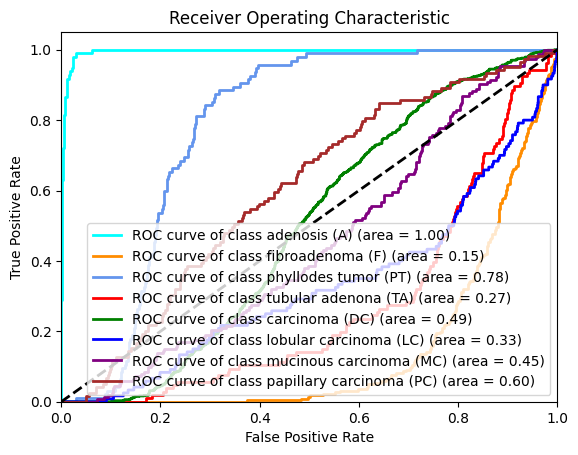

In [10]:
# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'brown']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Encoding images try 2 - saving embeddings to one csv file

In [ ]:
import os
import torch
from PIL import Image
from tqdm import tqdm

# Assuming model and preprocess are already defined
# model = ...
# preprocess = ...

def load_and_encode_images(tensor_folder, model, device):
    """
    Load preprocessed tensors and encode images using the CONCH model.
    Args:
        tensor_folder (str): Path to the folder containing preprocessed tensors.
        model (torch.nn.Module): Pretrained CONCH model for encoding images.
        device (torch.device): Device to run the model on (CPU or GPU).
    
    Returns:
        dict: A dictionary with tensor filenames as keys and image embeddings as values.
    """
    embeddings = {}
    
    for tensor_file in tqdm(os.listdir(tensor_folder)):
        if tensor_file.endswith(".pt"):
            tensor_path = os.path.join(tensor_folder, tensor_file)
            tensor = torch.load(tensor_path).to(device)
            
            with torch.inference_mode():
                image_embs = model.encode_image(tensor, proj_contrast=False, normalize=False)
            
            embeddings[tensor_file] = image_embs.cpu().numpy()
    
    return embeddings

def save_embeddings(embeddings, output_path):
    """
    Save image embeddings to a file.
    Args:
        embeddings (dict): Dictionary with tensor filenames as keys and image embeddings as values.
        output_path (str): Path to save the embeddings file.
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(embeddings, output_path)

# Example usage
tensor_folder = r"C:\Users\Vivian\Documents\CONCH\data_tensors"
embedding_output_path = r"C:\Users\Vivian\Documents\CONCH\image_embeddings.pt"

# Load and encode images
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
embeddings = load_and_encode_images(tensor_folder, model, device)

# Save embeddings to a file
save_embeddings(embeddings, embedding_output_path)
print("Embeddings saved to file")

In [ ]:
import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Define the labels and classes
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']
classes = ["adenosis (A)", "fibroadenoma (F)", "phyllodes tumor (PT)", "tubular adenona (TA)", "carcinoma (DC)", "lobular carcinoma (LC)", "mucinous carcinoma (MC)", "papillary carcinoma (PC)"]

# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to load features and labels
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_embeddings.pt"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = torch.load(feature_path).to('cpu').numpy()
            feature = feature.flatten()
            features.append(feature)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
    return np.array(features), np.array(labels)

# Load data
feature_folder = r"C:\Users\Vivian\Documents\CONCH\data_embeddings"
X, y = load_features_and_labels(feature_folder, labels_list)

# Map labels to class names
y = np.array([classes[labels_list.index(label)] for label in y])

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Binarize the labels for ROC curve plotting
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test data
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'brown']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()